<small><font color=gray>Notebook authors: <a href="https://www.linkedin.com/in/olegmelnikov/" target="_blank">Oleg Melnikov</a>, <a href="https://www.hse.ru/en/org/persons/223985242/" target="_blank">Alexey Boldyrev</a>, <a href="https://www.hse.ru/en/staff/mekarpov" target="_blank">Maksim Karpov</a> ©2024</font></small><hr style="margin:0;background-color:silver">

**[<font size=6>👂Phonemes</font>](https://www.kaggle.com/t/770d1b2601fd4bf79cb131de66dd050b)**. [**Instructions**](https://colab.research.google.com/drive/1owkYjuRGkx050LQnM3b3yTzd0Dr2XbeV) for running Colabs.

We consent to sharing our Colab (after the assignment ends) with other students/instructors for educational purposes.


In [517]:
from google.colab import drive; drive.mount('/content/drive')   # OK to enable, if your kaggle.json is stored in Google Drive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [518]:
!pip -q install --upgrade --force-reinstall --no-deps kaggle > log  # upgrade kaggle package (to avoid a warning)
!mkdir -p ~/.kaggle                                           # .kaggle folder must contain kaggle.json for kaggle executable to properly authenticate you to Kaggle.com
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json >log  # First, download kaggle.json from kaggle.com (in Account page) and place it in the root of mounted Google Drive
# !cp kaggle.json ~/.kaggle/kaggle.json > log                   # Alternative location of kaggle.json (without a connection to Google Drive)
!chmod 600 ~/.kaggle/kaggle.json                              # give only the owner full read/write access to kaggle.json
!kaggle config set -n competition -v 15-nov-24-hse-phonemes   # set the competition context for the next few kaggle API calls. !kaggle config view - shows current settings
!kaggle competitions download >> log                          # download competition dataset as a zip file
!unzip -o *.zip >> log                                        # Kaggle dataset is copied as a single file and needs to be unzipped.
!kaggle competitions leaderboard --show                     # print public leaderboard

- competition is now set to: 15-nov-24-hse-phonemes
Using competition: 15-nov-24-hse-phonemes
  teamId  teamName         submissionDate       score    
--------  ---------------  -------------------  -------  
12996667  M Team           2024-11-23 17:31:56  0.95020  
12960373  👂 AM             2024-11-24 15:40:39  0.94840  
12954478  S                2024-11-24 14:37:55  0.94780  
12955319  L                2024-11-24 14:26:20  0.94440  
12961949  AH_team          2024-11-24 15:01:46  0.93920  
12948118  R_Phonemes       2024-11-23 20:45:09  0.93920  
12947168  👂 D              2024-11-24 14:36:37  0.93860  
12958227  F team           2024-11-24 14:02:35  0.93600  
12949488  Team X           2024-11-24 07:11:42  0.93480  
12954346  Team Y           2024-11-24 12:06:02  0.93380  
12947644  AI Team          2024-11-24 14:50:25  0.93340  
12950755  AA_Team          2024-11-24 13:39:20  0.93320  
12948429  W Team           2024-11-24 15:42:05  0.93260  
12979581  AN team          2024-11-2

In [519]:
%%time
%%capture
%reset -f
from IPython.core.interactiveshell import InteractiveShell as IS; IS.ast_node_interactivity = "all"
import numpy as np, pandas as pd, time, matplotlib.pyplot as plt, seaborn as sns, os, tqdm, re, sys, cv2, skimage, xgboost, lightgbm as lgb, librosa
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression as LR
from sklearn.ensemble import GradientBoostingClassifier as GBC
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA, LinearDiscriminantAnalysis as LDA
ToCSV = lambda df, fname: df.round(2).to_csv(f'{fname}.csv', index_label='id') # rounds values to 2 decimals

class Timer():
  def __init__(self, lim:'RunTimeLimit'=60): self.t0, self.lim, _ = time.time(), lim, print(f'⏳ started. You have {lim} sec. Good luck!')
  def ShowTime(self):
    msg = f'Runtime is {time.time()-self.t0:.0f} sec'
    print(f'\033[91m\033[1m' + msg + f' > {self.lim} sec limit!!!\033[0m' if (time.time()-self.t0-1) > self.lim else msg)

np.set_printoptions(linewidth=100, precision=2, edgeitems=2, suppress=True)
pd.set_option('display.max_columns', 20, 'display.precision', 2, 'display.max_rows', 4)

CPU times: user 612 ms, sys: 76.8 ms, total: 689 ms
Wall time: 1.08 s


In [520]:
df = pd.read_csv('XY_Phonemes.csv', low_memory=False); df

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,x249,x250,x251,x252,x253,x254,x255,x256,SpkrID,g
0,11.14,15.17,19.12,18.78,13.79,18.98,20.09,19.16,17.32,19.76,...,7.79,10.95,10.05,8.67,10.84,9.50,7.96,9.04,0,NaN
1,10.84,15.20,19.80,17.82,14.10,17.93,19.54,20.97,16.65,22.41,...,12.95,13.05,11.95,11.07,10.81,9.71,11.57,12.22,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59998,12.15,15.78,21.27,19.61,15.14,21.44,23.24,20.91,17.42,21.22,...,8.82,8.00,7.44,8.32,6.51,8.33,6.83,7.02,436,ao
59999,14.78,14.08,15.70,15.51,15.36,15.52,14.68,15.57,15.48,15.45,...,12.87,13.26,13.16,12.65,13.90,13.10,11.16,13.53,436,sh


In [521]:
df.info()   # observe datatypes and any missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 258 entries, x1 to g
dtypes: float64(256), int64(1), object(1)
memory usage: 118.1+ MB


In [522]:
vX = df.query('g!=g').drop('g', axis=1)  # slice a test sample (10K observations)
tXY = df.query('g==g')                   # slice training sample
tX, tY = tXY.drop('g', axis=1), tXY.g    # split into training I/O (60K-10K = 50K observation)

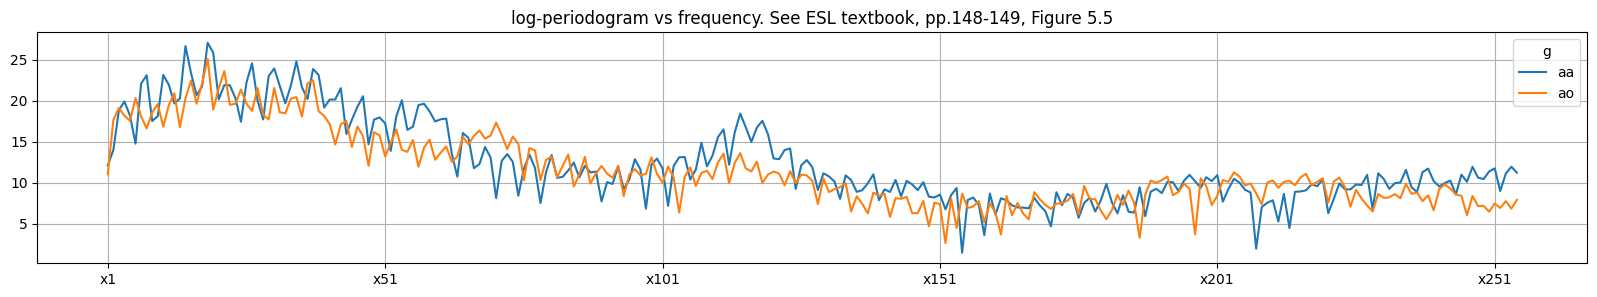

In [523]:
aa = tXY[tXY.g=='aa'].set_index('g').iloc[[0],0:255]
ao = tXY[tXY.g=='ao'].set_index('g').iloc[[0],0:255]
_ = pd.concat([aa,ao]).T.plot(figsize=(20,3), grid=True, title='log-periodogram vs frequency. See ESL textbook, pp.148-149, Figure 5.5');

In [524]:
tmr = Timer()

⏳ started. You have 60 sec. Good luck!


<hr color=green size=40>

<strong><font color=green size=5>⏳Timed Green Playground (TGP): Your ideas, code, documentation, and timer START HERE!</font></strong>

<font color=green>Students: Keep all your definitions, code, documentation in <b>TGP</b>. Modifying any code outside of TGP incurs penalties.

In [525]:
from sklearn.preprocessing import StandardScaler

In [526]:
tXY.T.iloc[:-2,:]

,10000,10001,10002,10003,10004,10005,10006,10007,10008,10009,...,59990,59991,59992,59993,59994,59995,59996,59997,59998,59999
x1,12.1,13.56,11.01,9.61,12.78,12.58,8.1,13.07,8.61,9.09,...,14.05,11.43,15.52,15.64,15.27,10.87,11.88,11.49,12.15,14.78
x2,13.98,13.88,17.63,7.71,13.66,15.44,8.55,12.54,8.73,7.73,...,12.71,16.01,16.12,14.24,14.37,7.21,15.76,13.08,15.78,14.08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
x255,11.22,11.33,7.91,4.67,13.71,6.01,16.26,6.64,16.4,4.76,...,12.11,7.19,17.01,11.56,11.74,6.3,7.04,10.26,6.83,11.16
x256,10.51,10.37,6.48,5.7,17.24,1.3,13.4,6.22,14.84,5.85,...,13.72,7.22,16.12,14.47,14.21,6.37,7.02,12.32,7.02,13.53


In [527]:
scaler = StandardScaler();
txy = scaler.fit_transform(tXY.T.iloc[:-2,:]);
txy = pd.DataFrame(txy);


In [528]:
scaler = StandardScaler();
vx = scaler.fit_transform(vX.T.iloc[:-1,:]);
vx = pd.DataFrame(vx);
vx

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
0,-0.18,-0.60,1.01,-0.64,1.04,0.53,0.64,0.41,-1.76,-1.03,...,-0.19,-1.67,-0.08,0.27,-0.10,-1.63,0.97,-1.66,1.21,0.13
1,0.73,0.70,1.63,-0.76,1.73,1.47,1.14,1.10,-1.69,-0.87,...,0.67,-3.23,0.30,0.99,1.33,-3.07,2.57,-3.05,2.73,1.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
254,-0.90,-0.38,-0.49,-1.05,-0.51,-0.06,0.27,0.23,-1.01,-0.37,...,-0.76,-0.83,-0.67,-0.99,-0.23,-1.04,-0.19,-0.93,-0.22,-0.47
255,-0.65,-0.18,-0.52,0.18,-0.51,-0.14,-0.12,-0.19,-1.05,-0.61,...,-0.82,-1.96,-1.06,-2.39,-0.13,-2.18,0.46,-2.06,0.40,-0.24


In [529]:
h = 1
#txy = txy.rolling(window=h).mean()
#vx = vx.rolling(window=h).mean()

In [530]:
vx

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
0,-0.18,-0.60,1.01,-0.64,1.04,0.53,0.64,0.41,-1.76,-1.03,...,-0.19,-1.67,-0.08,0.27,-0.10,-1.63,0.97,-1.66,1.21,0.13
1,0.73,0.70,1.63,-0.76,1.73,1.47,1.14,1.10,-1.69,-0.87,...,0.67,-3.23,0.30,0.99,1.33,-3.07,2.57,-3.05,2.73,1.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
254,-0.90,-0.38,-0.49,-1.05,-0.51,-0.06,0.27,0.23,-1.01,-0.37,...,-0.76,-0.83,-0.67,-0.99,-0.23,-1.04,-0.19,-0.93,-0.22,-0.47
255,-0.65,-0.18,-0.52,0.18,-0.51,-0.14,-0.12,-0.19,-1.05,-0.61,...,-0.82,-1.96,-1.06,-2.39,-0.13,-2.18,0.46,-2.06,0.40,-0.24


In [531]:
txy = txy.T
txy.index += 10000;
txy.columns += 1
txy.columns = 'x' + txy.columns.astype(str);



In [532]:
vx = vx.T
vx.columns += 1
vx.columns = 'x' + vx.columns.astype(str);

In [533]:
txy = txy.join(tXY.loc[:,['SpkrID', 'g']])
txy = txy.iloc[:,h-1:]
txy

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,x249,x250,x251,x252,x253,x254,x255,x256,SpkrID,g
10000,-0.07,0.30,1.26,1.47,1.13,0.45,1.89,2.10,1.00,1.11,...,-0.40,-0.21,-0.14,-0.68,-0.26,-0.10,-0.24,-0.38,100,aa
10001,0.23,0.29,1.47,1.35,1.22,0.52,1.54,1.93,0.99,0.90,...,-0.25,-0.03,-0.16,-0.56,-0.24,-0.19,-0.21,-0.41,100,aa
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59998,0.02,0.76,1.89,1.55,0.63,1.92,2.29,1.82,1.10,1.88,...,-0.67,-0.83,-0.95,-0.77,-1.14,-0.77,-1.07,-1.03,436,ao
59999,-0.32,-0.76,0.26,0.14,0.05,0.15,-0.38,0.18,0.12,0.10,...,-1.51,-1.27,-1.33,-1.65,-0.87,-1.37,-2.59,-1.10,436,sh


In [534]:
vx = vx.join(vX.loc[:,['SpkrID']])
vx = vx.iloc[:,h-1:]
vx

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,x248,x249,x250,x251,x252,x253,x254,x255,x256,SpkrID
0,-0.18,0.73,1.62,1.54,0.42,1.59,1.84,1.63,1.21,1.76,...,-0.59,-0.93,-0.22,-0.42,-0.74,-0.25,-0.55,-0.90,-0.65,0
1,-0.60,0.70,2.07,1.48,0.38,1.52,2.00,2.42,1.14,2.85,...,0.02,0.03,0.06,-0.27,-0.53,-0.61,-0.93,-0.38,-0.18,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9998,1.21,2.73,3.44,3.56,1.43,2.72,2.53,1.91,3.93,3.74,...,-0.26,0.17,-0.06,0.33,0.27,-0.59,-0.48,-0.22,0.40,99
9999,0.13,1.50,2.02,1.35,1.35,1.70,1.08,1.87,2.10,1.68,...,-1.30,-0.87,-1.09,-0.92,-0.87,-1.16,-0.65,-0.47,-0.24,99


In [535]:
tY, tX = txy.g, txy.drop('g', axis=1)     # split into training I/O (60K-10K = 50K observation)

In [536]:
vX = vx


In [537]:
# from scipy.signal import savgol_filter
#spline = aa.apply(lambda x: savgol_filter(x, 10, 3))


In [538]:
# def savgol(obs):
#     return savgol_filter(obs, 10, 3)

In [539]:
# n=10
# splines = aa.iloc[[0],:-1].apply(lambda x: savgol_filter(x, n, 3), axis=1)
# splines

In [540]:
txy

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,x249,x250,x251,x252,x253,x254,x255,x256,SpkrID,g
10000,-0.07,0.30,1.26,1.47,1.13,0.45,1.89,2.10,1.00,1.11,...,-0.40,-0.21,-0.14,-0.68,-0.26,-0.10,-0.24,-0.38,100,aa
10001,0.23,0.29,1.47,1.35,1.22,0.52,1.54,1.93,0.99,0.90,...,-0.25,-0.03,-0.16,-0.56,-0.24,-0.19,-0.21,-0.41,100,aa
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59998,0.02,0.76,1.89,1.55,0.63,1.92,2.29,1.82,1.10,1.88,...,-0.67,-0.83,-0.95,-0.77,-1.14,-0.77,-1.07,-1.03,436,ao
59999,-0.32,-0.76,0.26,0.14,0.05,0.15,-0.38,0.18,0.12,0.10,...,-1.51,-1.27,-1.33,-1.65,-0.87,-1.37,-2.59,-1.10,436,sh


<font color=green><h3><b>$\alpha$. Build polynomial features</b><h3>

In [541]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

var = []
restore = []
#N = 121
N = 50
#for N in range(3, tX.shape[1]):
print(f"Number of components: {N} ")
pca = PCA(n_components=N)
pca.fit(tX, tY)

# Получение абсолютных значений компонентов
components_abs = np.abs(pca.components_)

# Выбор 100 наиболее значимых признаков
top_N_features = np.argsort(components_abs.sum(axis=0))[-N:]

# Создание нового набора данных с выбранными признаками
tX_pca = tX.iloc[:, top_N_features]

# Применение обратной трансформации PCA для проверки результатов
X_reconstructed = pca.inverse_transform(tX_pca)
X_reconstructed.columns = 'x' + X_reconstructed.columns.astype(str)
#var.append(pca.explained_variance_ratio_.sum())
restore.append(np.mean((tX - X_reconstructed) ** 2))

#print(f'number of features: {var.index(max(var))}, var: {max(var)}')
# Проверка, насколько хорошо оригинальные данные восстановлены
print(f"Дисперсия объясняемой информации: {pca.explained_variance_ratio_.sum()}")
print(f"Коэффициент восстановления: {np.mean((tX - X_reconstructed))**2}")
vX_pca = vX.iloc[:, top_N_features]


Number of components: 50 


PCA(n_components=50)

Дисперсия объясняемой информации: 0.9957503050850209
Коэффициент восстановления: 1.1028891908408098


In [542]:
tX = tX_pca
vX = vX_pca

In [543]:
%%time
n = 10000   # validation subsample
vX0, vY0 = tX.iloc[:n,:], tY[:n]   # subsample for model selection experiments
tX0, tY0 = tX.iloc[0:,:], tY[0:] # subsample for model training

poly = PolynomialFeatures(degree=1)    # add non-linear features (powers and interactions)
tX0p = poly.fit_transform(tX0.select_dtypes(include=np.number))  # create object on training set
vX0p = poly.transform(vX0.select_dtypes(include=np.number))      # apply the same object to test set
vXp  = poly.transform(vX.select_dtypes(include=np.number))       # apply the same object to test set

CPU times: user 40.6 ms, sys: 984 µs, total: 41.6 ms
Wall time: 51.7 ms


<Axes: >

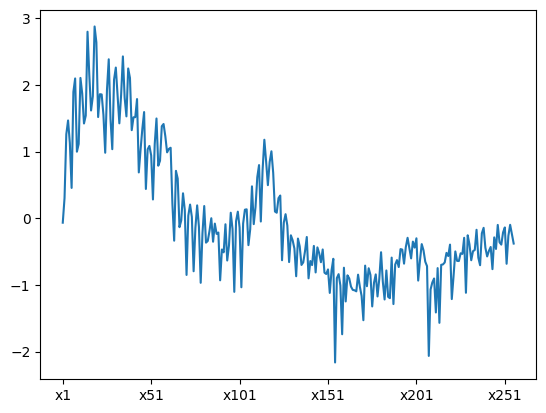

In [544]:
pl = txy.iloc[0,:-2]
pl.plot()

<font color=green><h3><b>$\beta$. Fit the model to the training dataset</b><h3>

In [545]:
m = LDA()

print(m.fit(tX0p, tY0).score(vX0p, vY0))   # fit the model and show test error

0.9193


In [546]:
#0.9173 - h=25
m.score

<bound method ClassifierMixin.score of LinearDiscriminantAnalysis()>

<font color=green><h3><b>$\gamma$. Generate predictions</b><h3>

In [547]:
pY = pd.DataFrame(m.predict(vXp), index=range(1,len(vXp)+1), columns=['g'])  # ensure that labels and observations are in corresponding order
pd.DataFrame(df.g.fillna('unknown').value_counts(sort=False)).rename(columns={'g':'observed output g'}).T   # distribution of all train labels
pd.DataFrame(pY.value_counts(sort=False)).rename(columns={0:'predicted output g'}).T
ToCSV(pY, 'and_another_one')

g,unknown,aa,ao,dcl,sh,iy
count,10000,7635,11197,8340,9674,13154


g,aa,ao,dcl,iy,sh
count,1447,2347,1530,2751,1925


<font color=green><h3><b>$\epsilon$. Documentation</b></h3></font>

<font color=green><h4><b>Task 1. Explain Decisions in Preprocessing Pipeline</b></h4></font>

<font color=green>
Explain elements of your preprocessing pipeline i.e. feature engineering, subsampling, clustering, dimensionality reduction, etc.</font>

<font color=green>

1. Why did you choose these elements? (Something in EDA, prior experience,...? Note: EDA is not required)
1. How do you evaluate the effectiveness of these elements?
1. What else have you tried that worked or didn't?

</font>

<font color=red><b>Your answer here.</b></font>

<font color=green><h4><b>Task 2. Explain Decisions in Modeling Pipeline</b></h4></font>

<font color=green>
Explain your modeling approach, i.e. ideas you tried and why you thought they would be helpful.

1. How did these decisions guide you in modeling?
1. How do you evaluate the effectiveness of these elements?
1. What else have you tried that worked or didn't?

</font>

<font color=red><b>Your answer here.</b></font>

<font color=green><h3><b>$\zeta$. References</b></h3></font>

<font color=red><b>Your answer here.</b></font>

<font color=green>
Cite your sources to help your peers learn from these (and to avoid plagiarism claims). At the least, HOML textbook should be cited. Use Google Scholar to draw APA citation format for books and publications. Also cite StackOverflow, package documentation, and other meaningful internet resources.

1. ...
1. ...

<font size=5>⌛</font> <strong><font color=green size=5>Do not exceed competition's runtime limit! Do not write code outside TGP</font></strong>
<hr color=green size=40>

In [548]:
tmr.ShowTime()    # measure Colab's runtime. Do not remove. Keep as the last cell in your notebook.

Runtime is 15 sec


## 💡**Starter Ideas**

1. Tune model hyperparameters
1. Try smarter sampling from the training set to avoid using all observations (due to time constraint) and, instead, develop more features
1. Try feature restriction, selection, and regularization (see ESL pp.140-141)
1. Do a thorough EDA: look for feature augmentations that result in linear decision boundaries between pairs of classes.
1. Try encoding and/or incorporating speaker ID. For example, you could scale/transform each speaker's observations separately.
1. Carefully read the example in [ESL textbook, p.149](https://hastie.su.domains/ElemStatLearn/printings/ESLII_print12.pdf#page=168), check seminar Colab and lecture slides
1. Check difference in distribution between test and train data. You might consider [group k-fold](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.model_selection) for testing locally or your model will memorize user-phoneme releation, instead of phoneme attributes and class.
1. Learn the domain to develop better features. See ["Penalized discriminant analysis"](https://scholar.google.com/scholar?hl=en&as_sdt=0%2C48&q=Penalized+Discriminant+Analysis&btnG=)
1. Look for training outliers that can affect your model's test performance.
  1. Essentially, you need to find and exclude training [influential points](https://en.wikipedia.org/wiki/Influential_observation), but training outliers might be influential
  1. Brute force with [LOOCV](https://en.wikipedia.org/wiki/Cross-validation_(statistics)#Leave-one-out_cross-validation) is slow, but robust. You might find methods to find each training point's contribution to the prediction and remove rare extreme contributors (since they may not be in the test set)
  1. You can find outliers; then evaluate their effect on model's performance
    1. You can evaluate 1D and 2D histograms to find outliers and
    1. You can cluster observations and find outliers that don't fit the clusters (DBSCAN may be helpful)
    1. You can compress high dimensional space to 1D (with PCA, tSNE, UMAP) and then find outliers with a histogram
 1. Additional info:
    1. Harmonics: [wiki](https://en.wikipedia.org/wiki/Harmonic), [sinusoidal regression](https://www.youtube.com/results?search_query=regression+sinusoidal)
    1. Discrete Fourier Transofrm (DFT): [wiki](https://en.wikipedia.org/wiki/Discrete_Fourier_transform), [Steve Brunton @UW](https://www.youtube.com/watch?v=nl9TZanwbBk), [YouTube search](https://www.youtube.com/results?search_query=Discrete+Fourier+transform)
    1. Spectral density estimation [(wiki)](https://en.wikipedia.org/wiki/Spectral_density_estimation), [YouTube search](https://www.youtube.com/results?search_query=spectral+density+estimation)


